In [ ]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    'width': 1280,
    'height': 800,
    'scroll': True
})

## Imports & Config

In [39]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from pathlib import Path
import sys
from os import environ
from inspect import getfile, currentframe
from os.path import join, dirname, abspath
from gensim.models import Word2Vec, KeyedVectors
import pandas as pd
import numpy as np
from numpy.linalg import norm
from numpy.random import permutation
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.style.use('ggplot')

In [2]:
def batches(l, n):
    """ Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [41]:
LANGUAGES = ['en', 'es']
translation_path = Path('translation')
if not translation_path.exists():
    translation_path.mkdir(parents=True, exist_ok=True)

## Load word2vec Models

In [6]:
model, words, vectors = {}, {}, {}
for language in LANGUAGES:
    file_name = 'word2vec/word_vectors/vectors_{}.bin'.format(language)
    model[language] = KeyedVectors.load_word2vec_format(file_name,
                                                        binary=True,
                                                        unicode_errors='ignore')
    words[language] = model[language].index2word
    vectors[language] = model[language].vectors
    vectors[language] /= norm(vectors[language], axis=1).reshape(-1, 1)

## Translate Top 10k English Terms

In [7]:
to_translate = words['en'][:10000]
pd.Series(to_translate).to_csv(translation_path / 'words_en.txt', index=False)

In [8]:
translated = pd.Series((translation_path / 'words_es.txt').read_text().split('\n'))
translated.count()

10000

In [9]:
matches = pd.DataFrame({'en': to_translate, 'es': translated})
matches.head()

,en,es
0,</s>,</ s>
1,the,el
2,of,de
3,and,y
4,in,en


In [10]:
word2id = {}
for language in LANGUAGES:
    word2id[language] = {w: i for i, w in enumerate(words[language])}

In [11]:
matches['es_id'] = matches.es.map(word2id['es'])
'Missing: {:.2%}'.format(matches.es_id.isnull().sum()/len(matches))

'Missing: 13.17%'

In [12]:
matches = matches.dropna().reset_index().rename(columns={'index': 'en_id'}).sort_index(1)
matches.es_id = matches.es_id.astype(int)
matches.head()

,en,en_id,es,es_id
0,the,1,el,2
1,of,2,de,1
2,and,3,y,5
3,in,4,en,4
4,to,5,a,6


In [13]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683 entries, 0 to 8682
Data columns (total 4 columns):
en       8683 non-null object
en_id    8683 non-null int64
es       8683 non-null object
es_id    8683 non-null int64
dtypes: int64(2), object(2)
memory usage: 271.4+ KB


## Learn Translation Matrix

### Model Settings

In [14]:
BATCH_SIZE = 100
TRAIN_SIZE = 5000
EARLY_STOP = 5
SOURCE_DIM = vectors['en'].shape[1]
TARGET_DIM = vectors['es'].shape[1]

### Train & Test Sets for  Source & Target Embeddings

In [15]:
source_id = matches.en_id.values
source_train = vectors['en'][source_id[:TRAIN_SIZE]]
source_test = vectors['en'][source_id[TRAIN_SIZE:]]

target_id = matches.es_id.values
target_train = vectors['es'][target_id[:TRAIN_SIZE]]
target_test = vectors['es'][target_id[TRAIN_SIZE:]]

### TensorFlow Graph

In [16]:
tf.logging.set_verbosity(tf.logging.INFO)

with tf.name_scope('inputs'):
    s = tf.placeholder(tf.float32, shape=[None, SOURCE_DIM], name='source')
    t_ = tf.placeholder(tf.float32, shape=[None, TARGET_DIM], name='target')

with tf.name_scope('parameters'):
    T = tf.Variable(
        tf.random_normal([SOURCE_DIM, TARGET_DIM]),
        name='translation_matrix'
    )
    tf.summary.histogram('histogram', T)

with tf.name_scope('inference'):
    t = tf.matmul(s, T, name='projection')
    # Regularized L2 Loss
    loss = tf.nn.l2_loss(t - t_, name='l2_loss') + .01 * tf.nn.l2_loss(T)

with tf.name_scope('training'):
    optimizer = tf.train.AdamOptimizer()
    train = optimizer.minimize(loss)

### Run TensorFlow Model

In [17]:
with tf.Session().as_default() as sess:
    tf.global_variables_initializer().run()

    test_loss = np.inf
    early_stop = 0
    losses = []
    
    while True:
        s_train, s_test, t_train, t_test = train_test_split(source_train, 
                                                            target_train, 
                                                            test_size=0.2,
                                                            random_state=42)
        
        for idx in batches(permutation(s_train.shape[0]), BATCH_SIZE):
            train.run(feed_dict={s: s_train[idx], t_: t_train[idx]})
            
        loss_ = sess.run(loss, feed_dict={s: s_test, t_: t_test})
        losses.append(loss_)
        
        if loss_ < test_loss:
            test_loss = loss_
            early_stop = 0
        else:
            early_stop += 1
        if early_stop == EARLY_STOP:
            break
            
    translation_matrix = T.eval(sess)

### Review Results

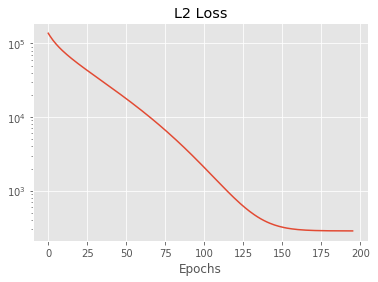

In [18]:
ax = pd.Series(losses).plot(title='L2 Loss', logy=True)
ax.set_xlabel('Epochs');

In [19]:
translation_matrix.shape

(300, 300)

### Evaluate Translation Accuracy

In [22]:
def get_accuracy(source, target, translation):
    source_projection = np.dot(source, translation)
    similarity = np.dot(source_projection, target.T)
    
    # Sort descending by index from left to right
    nearest_neighbors = np.fliplr(similarity.argsort(axis=1)) 
    
    # Get ranking of correct prediction
    _, rank = np.where(nearest_neighbors == np.arange(target.shape[0]).reshape(-1, 1))
    return pd.Series(data=rank).add(1), nearest_neighbors

#### Train Accuracy

In [31]:
ranking, nn_train = get_accuracy(source_train, target_train, translation_matrix)
train_accuracy = ranking.value_counts().sort_index()
train_precision = train_accuracy.cumsum().div(len(ranking)).iloc[:10]
train_precision = train_precision.to_frame('Train: n={:,d}'.format(len(ranking)))

#### Test Accuracy

In [32]:
ranking, nn_test = get_accuracy(source_test, target_test, translation_matrix)
test_accuracy = ranking.value_counts().sort_index()
test_precision = test_accuracy.cumsum().div(len(ranking)).iloc[:10].iloc[:10]
test_precision = test_precision.to_frame('Test: n={:,d}'.format(len(ranking)))

#### Plot Results

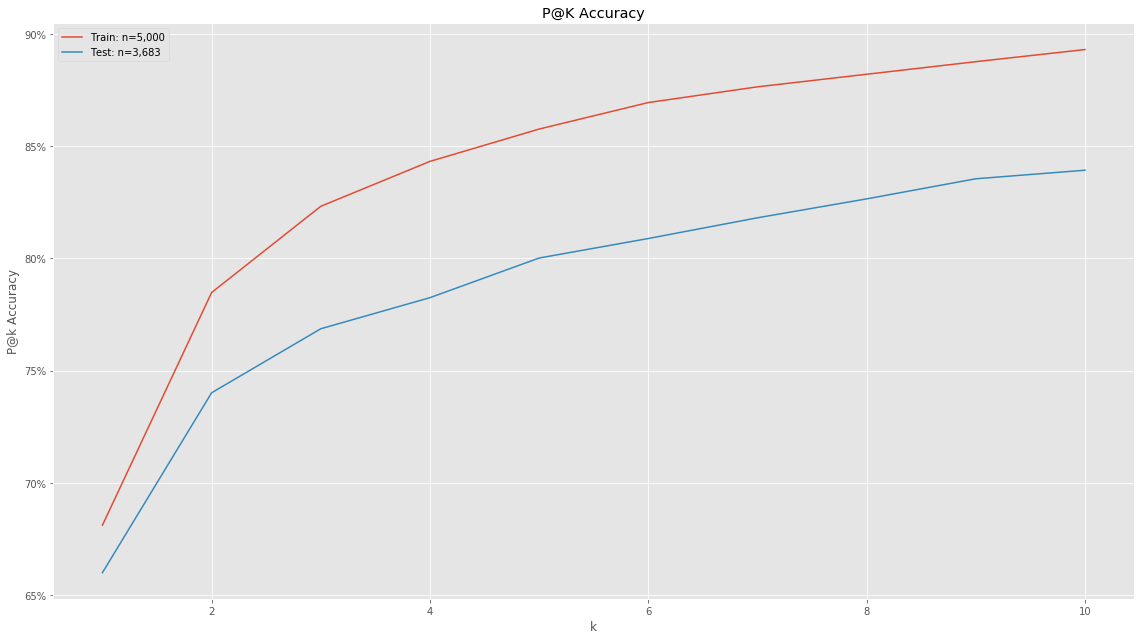

In [34]:
result = pd.concat([train_precision, test_precision], axis=1)
ax = result.plot(title='P@K Accuracy', figsize=(16,9))
ax.set_xlabel('k')
ax.set_ylabel('P@k Accuracy')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.gcf().savefig('assets/translation_accuracy.png', dpi=300);

#### View Translations

In [35]:
top_5_preds = pd.DataFrame(nn_train[:, :5], index=matches.en.iloc[:TRAIN_SIZE])

for col in top_5_preds.columns:
    top_5_preds[col] = top_5_preds[col].map(matches.es.to_dict())
print(top_5_preds.head(10))

        0       1       2       3             4
en                                             
the    el      el      la      de            de
of     de      de      el      el            la
and     y       y      de      de           con
in     en      en      de      de             y
to      a       a    para     que  directamente
a      un      un      el      el           que
was   era  estaba      es      es            es
is     es      es      es  existe        existe
for  para  además  además  además        además
on     en      en      de      de            el


In [36]:
with pd.HDFStore(translation_path / 'results.h5') as store:
    store.put('translation_matrix', pd.DataFrame(translation_matrix))
    store.put('top_5_preds', top_5_preds)
    store.put('accuracy', result)

### Visualize Bilingual Vector Space in `tensorboard`

#### Embeddings

In [37]:
LIMIT = 2500
source_projection = np.dot(source_test, translation_matrix)
projector_data = pd.DataFrame(np.vstack((source_projection[:LIMIT], 
                                         target_test[:LIMIT])))
projector_data.to_csv(translation_path / 'embeddings.tsv', index=False, sep='\t', header=None)
projector_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 300 entries, 0 to 299
dtypes: float32(300)
memory usage: 5.7 MB


#### Meta Data

In [38]:
labels = pd.melt(matches.iloc[TRAIN_SIZE:TRAIN_SIZE+LIMIT].loc[:, ['en', 'es']],
                 var_name='language', 
                 value_name='word')
labels.to_csv(translation_path / 'meta_data.tsv', index=False, sep='\t')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
language    5000 non-null object
word        5000 non-null object
dtypes: object(2)
memory usage: 78.2+ KB


## Resources

- [Exploiting similarities among languages for machine translation](https://arxiv.org/pdf/1309.4168)